In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quad_tdc_bend
from phase_space_reconstruction.virtual.scans import run_3d_scan_2screens
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.visualization import plot_3d_scan_data_2screens
from phase_space_reconstruction.utils import split_2screen_dset

from bmadx.distgen_utils import create_beam
from bmadx.plot import plot_projections
from bmadx.constants import PI

from stats import plot_projections_with_contours

In [20]:
# implement constant colormap for every screen:
def plot_3d_scan_data_2screens(dset, select_img = 'avg', splitted = True):
    imgs = dset.images[:,:,:,0,:,:]
    if select_img == 'avg':
        imgs = dset.images.sum(dim=-3)
        imgs = imgs / imgs.shape[-3]
    else:
        imgs = dset.images[:,:,:,select_img,:,:]
    vmax = dset.images.max()
    params = dset.params
    n_k = params.shape[0]
    n_v = params.shape[1]
    n_g = params.shape[2]
    fig, ax = plt.subplots(
        n_v * n_g + 1,
        n_k + 1,
        figsize=( (n_k+1)*2, (n_v*n_g+1)*2 )
    )
    ax[0, 0].set_axis_off()
    ax[0, 0].text(1, 0, '$k_1$ (1/m$^2$)', va='bottom', ha='right')
    for i in range(n_k):
        ax[0, i + 1].set_axis_off()
        ax[0, i + 1].text(
            0.5, 0, f'{params[i, 0, 0, 0]:.1f}', va='bottom', ha='center'
        )
        for j in range(n_g):
            for k in range(n_v):
                ax[2 * j + k + 1, i + 1].imshow(
                    imgs[i, k, j].T, 
                    origin='lower', 
                    interpolation='none',
                    vmin=0,
                    vmax=vmax
                )
                ax[2 * j + k + 1, i + 1].tick_params(
                    bottom=False, left=False,
                    labelbottom=False, labelleft=False
                )

                if k == 0:
                    v_lbl = "off"
                else:
                    v_lbl = "on"
                if j == 0:
                    g_lbl = "off"
                else:
                    g_lbl = "on"

                ax[2 * j + k + 1, 0].set_axis_off()
                ax[2 * j + k + 1, 0].text(
                    1, 0.5, f'T.D.C.: {v_lbl}\n DIPOLE: {g_lbl}',
                    va='center', ha='right'
                )

    return fig, ax

def get_beam_fraction_hist2d(hist2d, fraction: float):
    levels = np.linspace(hist2d.max(), 0.0, 100)
    total = hist2d.sum()
    final_beam = np.copy(hist2d)
    for level in levels:
        test_beam = np.where(hist2d>=level, hist2d, 0.0)
        test_frac = test_beam.sum() / total
        if test_frac > fraction:
            final_beam = test_beam
            break

    return final_beam

from scipy.ndimage import gaussian_filter

def plot_3d_scan_data_2screens_contour(
    pred_dset, 
    test_dset, 
    select_img = 'avg', 
    contour_percentiles = [50, 95],
    contour_smoothing_r = 1,
    contour_smoothing_gt = 1
):
    vmax = pred_dset.images.max()
    n_contours = len(contour_percentiles)
    COLORS = ["white", "gray", "black"]
    COLORS = COLORS * (n_contours // int(len(COLORS)+0.1) + 1)
    pred_imgs = pred_dset.images[:,:,:,0,:,:]
    test_imgs = test_dset.images[:,:,:,0,:,:]
    if select_img == 'avg':
        test_imgs = test_dset.images.sum(dim=-3)
        test_imgs = test_imgs / test_imgs.shape[-3]
    else:
        test_imgs = test_dset.images[:,:,:,select_img,:,:]
        
    params = pred_dset.params
    n_k = params.shape[0]
    n_v = params.shape[1]
    n_g = params.shape[2]
    fig, ax = plt.subplots(
        n_v * n_g + 1,
        n_k + 1,
        figsize=( (n_k+1)*2, (n_v*n_g+1)*2 )
    )
    ax[0, 0].set_axis_off()
    ax[0, 0].text(1, 0, '$k_1$ (1/m$^2$)', va='bottom', ha='right')
    for i in range(n_k):
        ax[0, i + 1].set_axis_off()
        ax[0, i + 1].text(
            0.5, 0, f'{params[i, 0, 0, 0]:.1f}', va='bottom', ha='center'
        )
        for j in range(n_g):
            for k in range(n_v):
                ax[2 * j + k + 1, i + 1].imshow(
                    pred_imgs[i, k, j].T,
                    origin='lower', 
                    interpolation='none', 
                    vmin=0, 
                    vmax=vmax
                )
                for l, percentile in enumerate(contour_percentiles):
                    '''
                    h_r_fractions = get_beam_fraction_hist2d(pred_imgs[i, k, j], percentile/100)
                    ax[2 * j + k + 1, i + 1].contour(
                        #x_centers, 
                        #y_centers, 
                        #gaussian_filter(h_r_fractions, contour_smoothing_r).T,
                        Z=h_r_fractions.T,
                        levels=[1],
                        linestyles="-",
                        colors=COLORS[l],
                        linewidths=1
                    )

                    h_gt_fractions = get_beam_fraction_hist2d(test_imgs[i,k,j], percentile/100)

                    ax[2 * j + k + 1, i + 1].contour(
                        #x_centers, 
                        #y_centers, 
                        #gaussian_filter(h_gt_fractions, contour_smoothing_gt).T,
                        Z=h_gt_fractions.T,
                        levels=[1],
                        linestyles="--",
                        colors=COLORS[l],
                        linewidths=1
                    )  
                    '''
                    h_r_fractions = get_beam_fraction_hist2d(pred_imgs[i, k, j], percentile/100)
                    h_gt_fractions = get_beam_fraction_hist2d(test_imgs[i,k,j], percentile/100)
                    ax[2 * j + k + 1, i + 1].contour(
                        #h_r_fractions.T,
                        gaussian_filter(h_r_fractions, contour_smoothing_r).T,
                        levels=[0],
                        linestyles="-",
                        colors=COLORS[l],
                        linewidths=1
                    )  
                    ax[2 * j + k + 1, i + 1].contour(
                        #h_gt_fractions.T,
                        gaussian_filter(h_gt_fractions, contour_smoothing_gt).T,
                        levels=[0],
                        linestyles="--",
                        colors=COLORS[l],
                        linewidths=1
                    ) 
                ax[2 * j + k + 1, i + 1].tick_params(
                    bottom=False, left=False,
                    labelbottom=False, labelleft=False
                )

                if k == 0:
                    v_lbl = "off"
                else:
                    v_lbl = "on"
                if j == 0:
                    g_lbl = "off"
                else:
                    g_lbl = "on"

                ax[2 * j + k + 1, 0].set_axis_off()
                ax[2 * j + k + 1, 0].text(
                    1, 0.5, f'T.D.C.: {v_lbl}\n DIPOLE: {g_lbl}',
                    va='center', ha='right'
                )

    return fig, ax

In [3]:
# load data
data_dir = '/Users/jpga/AWA_DATA/12-07_6D-PSR/reconstruction_scan'
save_dir =  'results'
dset = torch.load(os.path.join(data_dir, 'dset_3d_12_07_full_scan.pt'))

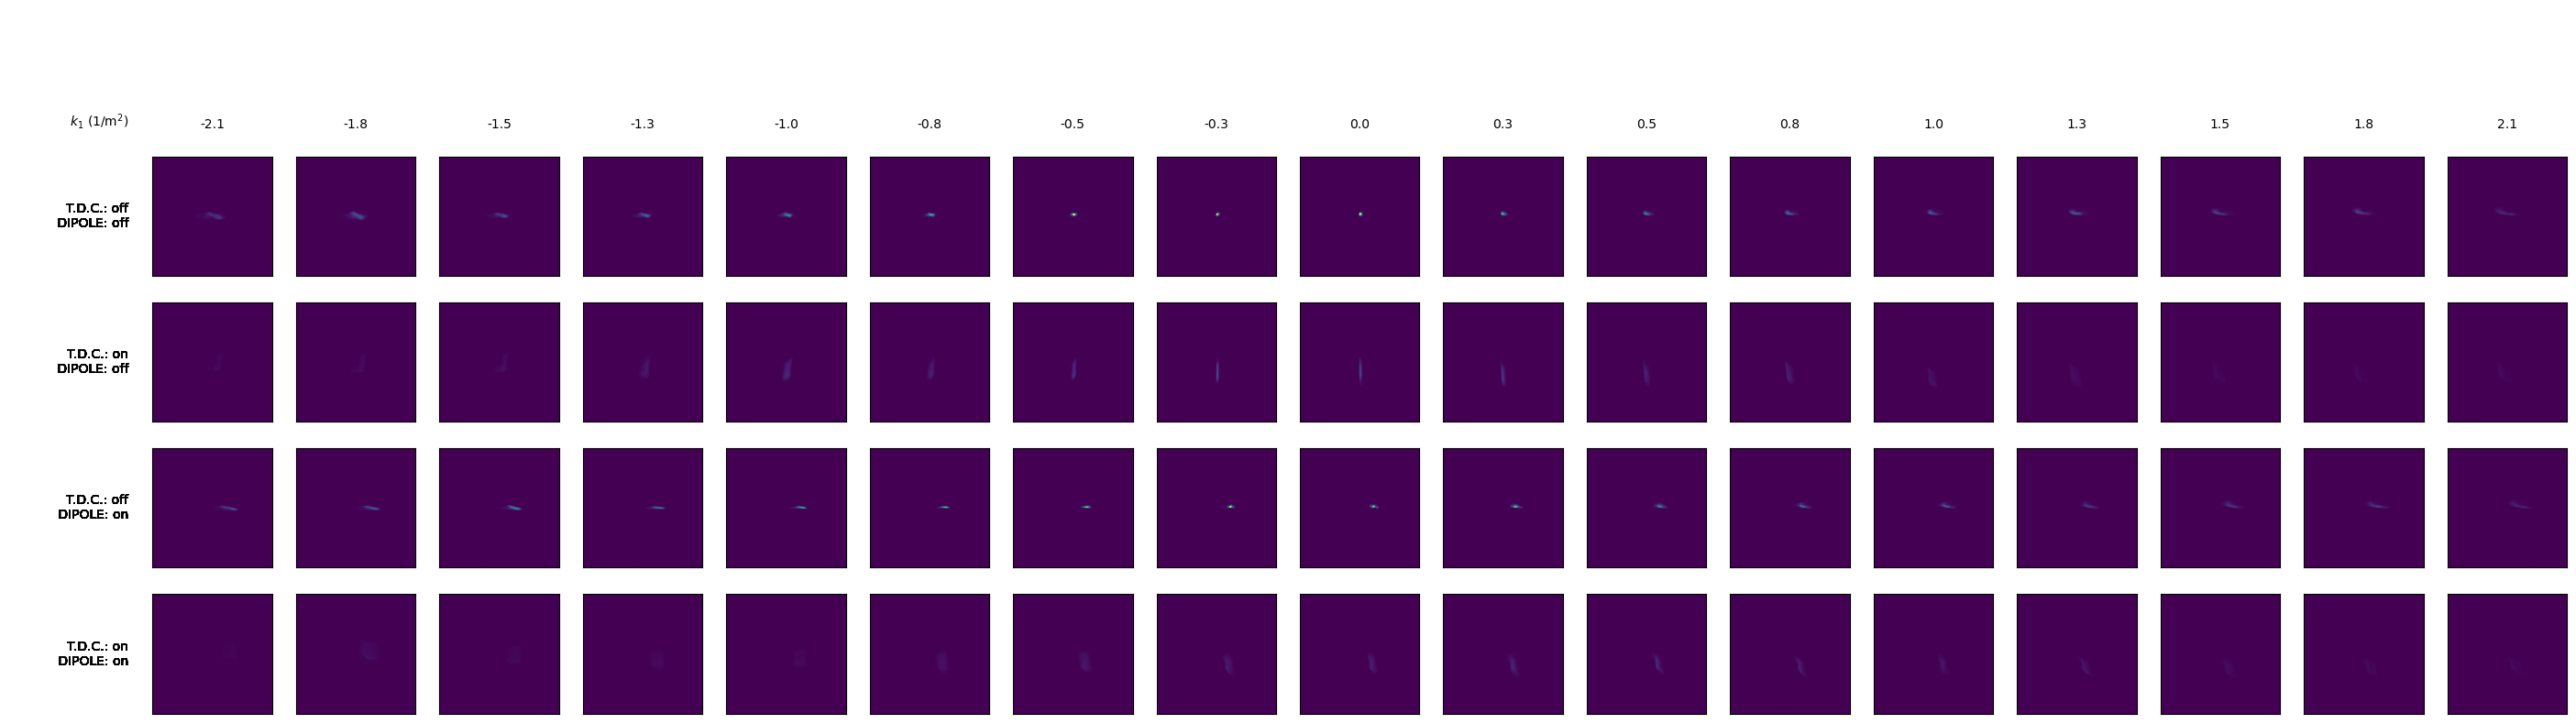

In [21]:
plot_3d_scan_data_2screens(dset)
plt.show()

In [5]:
dset.images.shape

torch.Size([17, 2, 2, 3, 700, 700])

In [6]:
from phase_space_reconstruction.modeling import ImageDataset3D

def clip_imgs(imgs, center, width):
    half_width = width // 2
    return imgs[Ellipsis, center-half_width:center+half_width, center-half_width:center+half_width]

def create_clipped_dset(dset, width):
    imgs = dset.images
    params = dset.params
    center = imgs.shape[-1] // 2
    clipped_imgs = clip_imgs(imgs, center, width)
    return ImageDataset3D(params, clipped_imgs)

In [7]:
clipped_dset = create_clipped_dset(dset, 400)
clipped_dset.images.shape

torch.Size([17, 2, 2, 3, 400, 400])

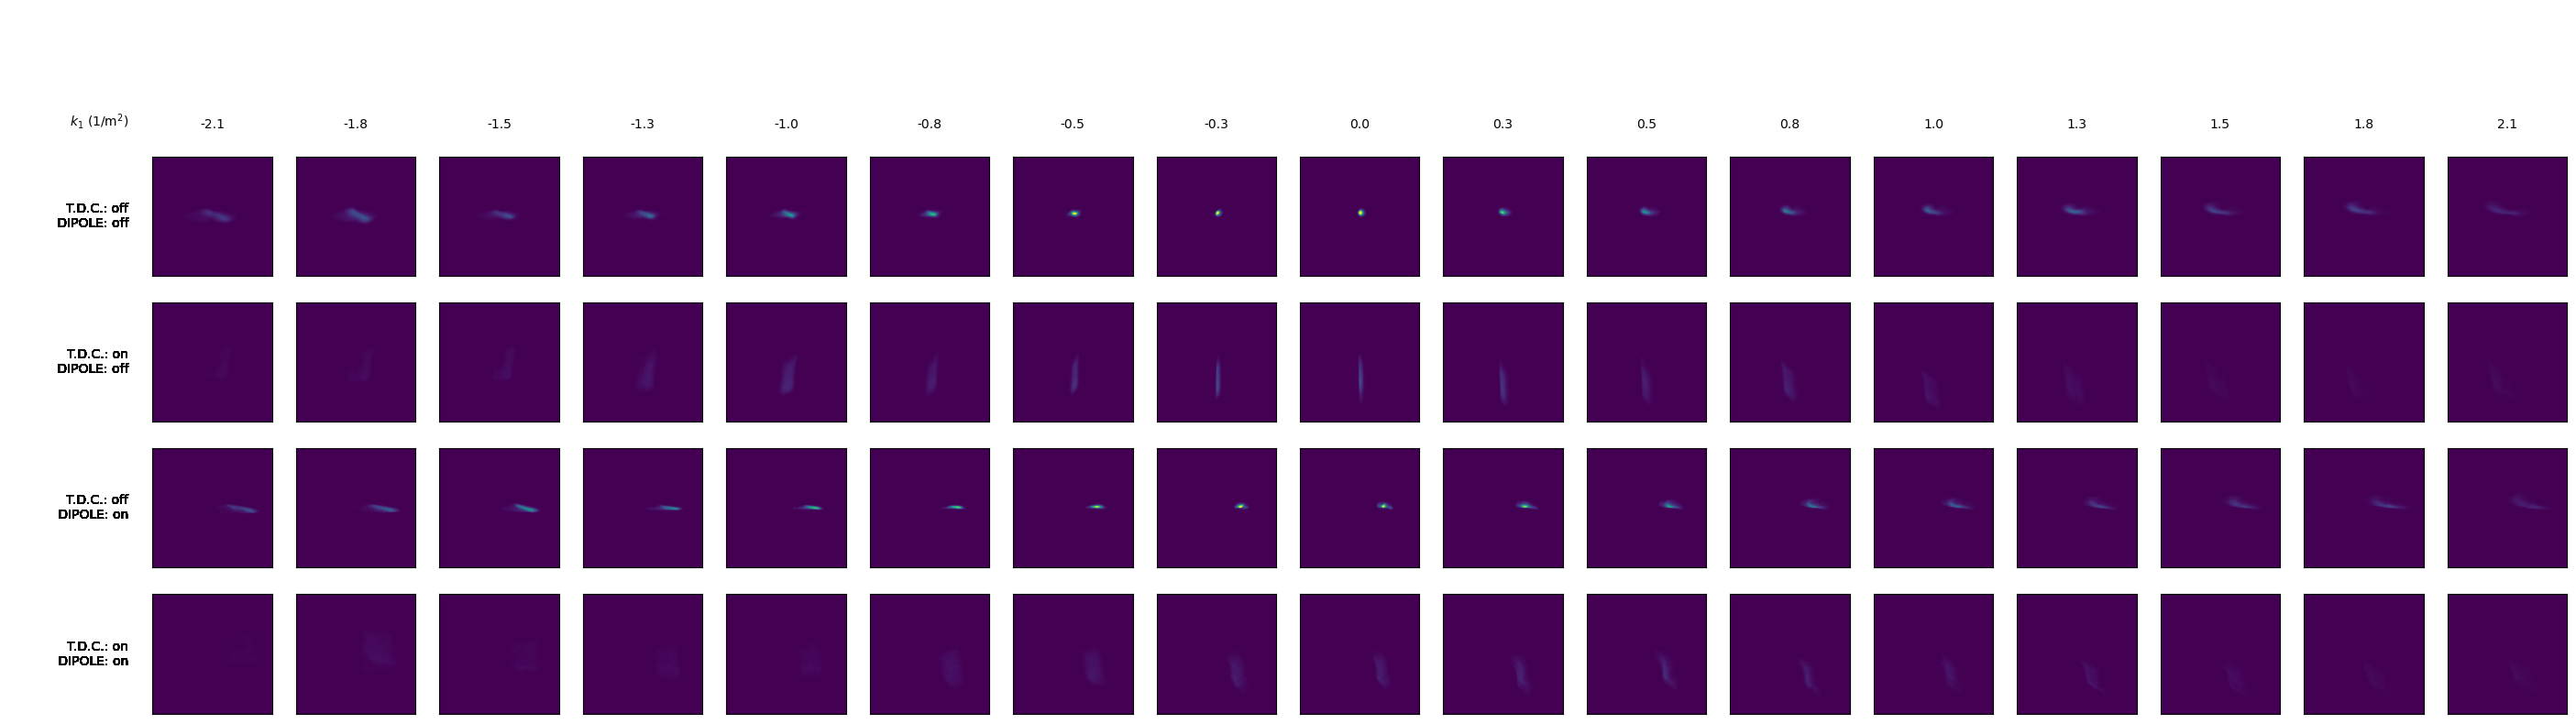

In [22]:
plot_3d_scan_data_2screens(clipped_dset)
plt.show()

In [9]:
train_dset, test_dset = split_2screen_dset(clipped_dset)

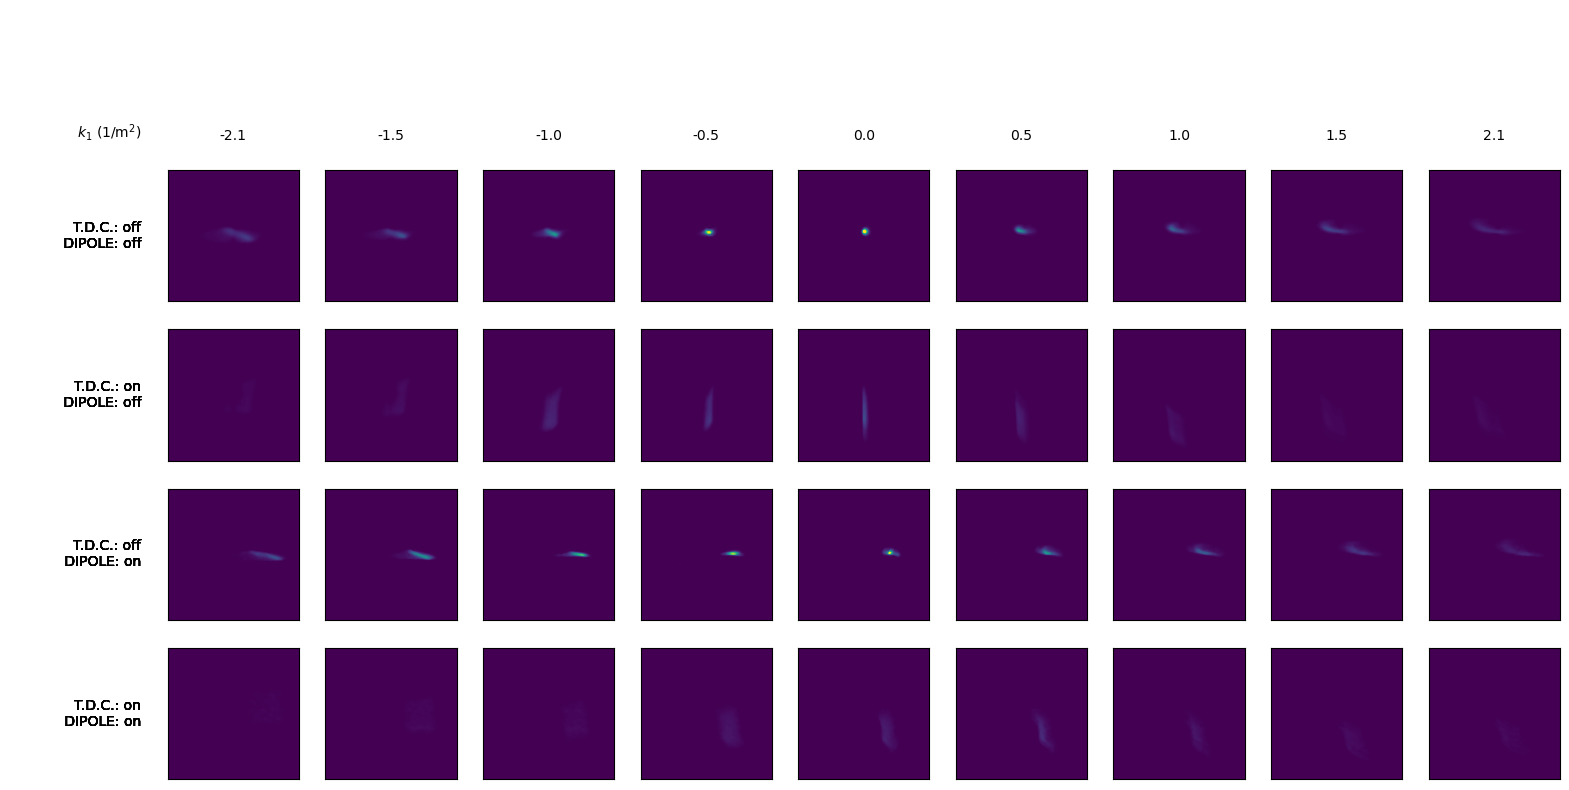

In [23]:
plot_3d_scan_data_2screens(train_dset)
plt.show()

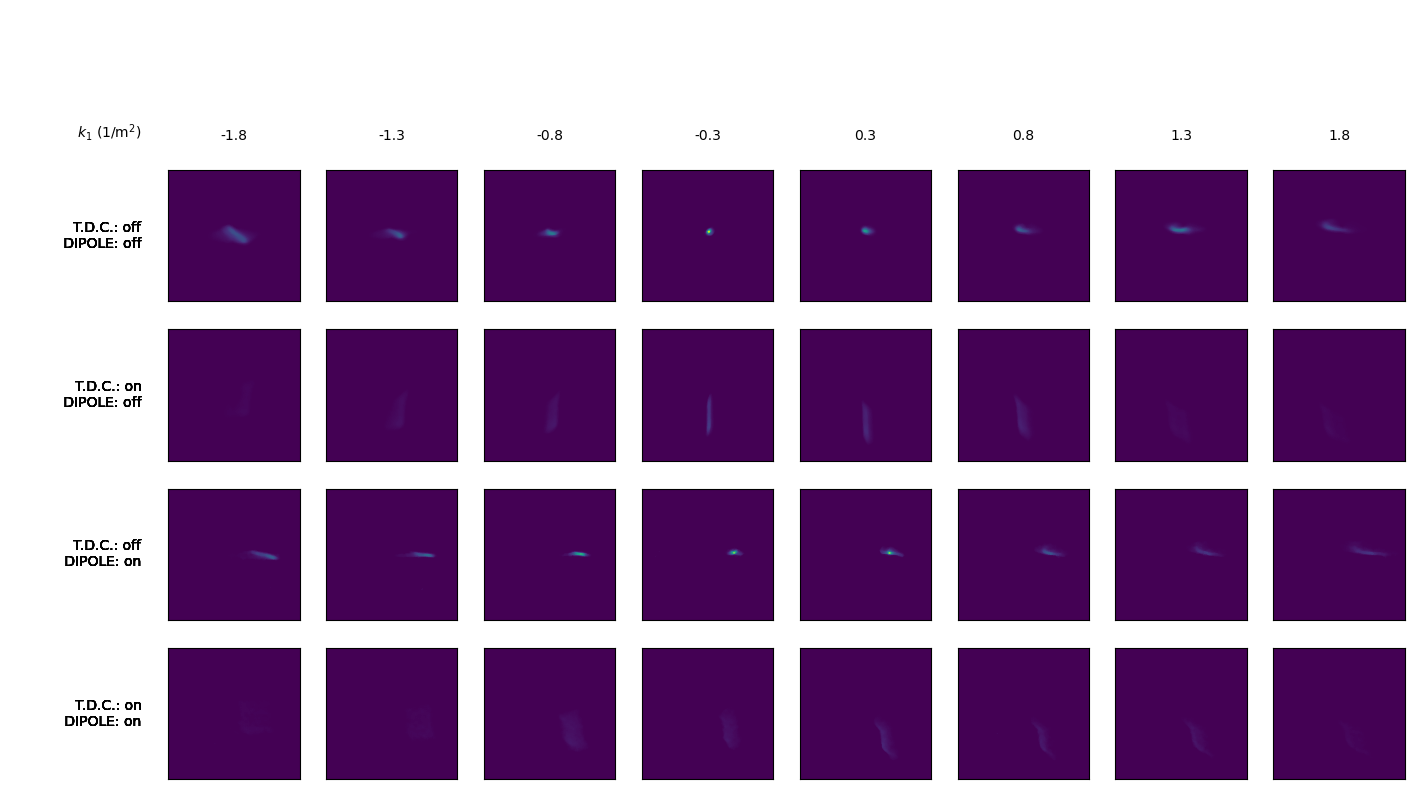

In [24]:
plot_3d_scan_data_2screens(test_dset, 2)
plt.show()

In [12]:
from bmadx import Particle
def numpy_to_torch_particles(particle: Particle):
    '''Returns Particle with torch tensors from particles with numpy arrays.'''
    return Particle(
        x = torch.tensor(particle.x),
        px = torch.tensor(particle.px),
        y = torch.tensor(particle.y),
        py = torch.tensor(particle.py),
        z = torch.tensor(particle.z),
        pz = torch.tensor(particle.pz),
        s = torch.tensor(particle.s),
        p0c = torch.tensor(particle.p0c),
        mc2 = torch.tensor(particle.mc2)
    )
pred_beam = numpy_to_torch_particles(torch.load('pred_beam.pt'))

In [13]:
def run_3d_scan_2screens(
    beam,
    lattice0,
    lattice1,
    screen0,
    screen1,
    params,
    n_imgs_per_param = 1,
    ids = [0, 2, 4],
    save_as = None
):

    # base lattices 
    #params = torch.meshgrid(ks, vs, gs, indexing='ij')
    #params = torch.stack(params, dim=-1)
    print(params.shape)
    params_dipole_off = params[:,:,0].unsqueeze(-1)
    print(params_dipole_off.shape)
    diagnostics_lattice0 = lattice0.copy()
    diagnostics_lattice0.elements[ids[0]].K1.data = params_dipole_off[:,:,0]
    diagnostics_lattice0.elements[ids[1]].VOLTAGE.data = params_dipole_off[:,:,1]
    diagnostics_lattice0.elements[ids[2]].G.data = params_dipole_off[:,:,2]

    params_dipole_on = params[:,:,1].unsqueeze(-1)
    diagnostics_lattice1 = lattice1.copy()
    diagnostics_lattice1.elements[ids[0]].K1.data = params_dipole_on[:,:,0]
    diagnostics_lattice1.elements[ids[1]].VOLTAGE.data = params_dipole_on[:,:,1]
    diagnostics_lattice1.elements[ids[2]].G.data = params_dipole_on[:,:,2]

    # track through lattice for dipole off(0) and dipole on (1)
    output_beam0 = diagnostics_lattice0(beam)
    output_beam1 = diagnostics_lattice1(beam)

    # histograms at screens for dipole off(0) and dipole on (1)
    images_dipole_off = screen0(output_beam0).squeeze()
    images_dipole_on = screen1(output_beam1).squeeze()

    # stack on dipole dimension:
    images_stack = torch.stack((images_dipole_off, images_dipole_on), dim=2)
    
    # create images copies simulating multi-shot per parameter config:
    copied_images = torch.stack([images_stack]*n_imgs_per_param, dim=-3)

    # create image dataset
    dset = ImageDataset3D(params, copied_images)
    
    # save scan data if wanted
    if save_as is not None:
        torch.save(dset, save_as)
        print(f"dataset0 saved as '{save_as}'")

    return dset

In [14]:
test_dset.params.shape

torch.Size([8, 2, 2, 3])

In [15]:
# diagnostic beamline:
p0c = 62.0e6
lattice0 = quad_tdc_bend(p0c=p0c, dipole_on=False)
lattice1 = quad_tdc_bend(p0c=p0c, dipole_on=True)

# Scan over quad strength, tdc on/off and dipole on/off
scan_ids = [0, 2, 4] 

# create 2 diagnostic screens: 
def create_screen(size, pixels):
    bins = torch.linspace(-size/2, size/2, pixels)
    bandwidth = (bins[1]-bins[0]) / 2
    return ImageDiagnostic(bins, bins, bandwidth)

screen0 = create_screen(30.22*1e-3*400/700, 400)
screen1 = create_screen(26.96*1e-3*400/700, 400)

In [16]:
pred_beam

Particle(x=tensor([-0.0001, -0.0025, -0.0004,  ...,  0.0042, -0.0002,  0.0030]), px=tensor([ 1.8223e-04,  1.0663e-03,  2.7264e-04,  ..., -1.8156e-03,
         9.4542e-05, -1.1084e-03]), y=tensor([ 4.5909e-05, -4.3407e-04,  1.1692e-03,  ...,  2.6207e-03,
        -1.9769e-04,  1.5540e-03]), py=tensor([ 0.0002,  0.0003, -0.0005,  ..., -0.0008,  0.0002, -0.0005]), z=tensor([-0.0011, -0.0015, -0.0001,  ..., -0.0003, -0.0014, -0.0019]), pz=tensor([0.0073, 0.0077, 0.0065,  ..., 0.0119, 0.0079, 0.0126]), s=tensor(0.), p0c=tensor(62000000.), mc2=tensor(510998.9375))

In [17]:
pred_dset = run_3d_scan_2screens(
    pred_beam,
    lattice0,
    lattice1,
    screen0,
    screen1,
    params=test_dset.params,
    ids=scan_ids
)

torch.Size([8, 2, 2, 3])
torch.Size([8, 2, 3, 1])


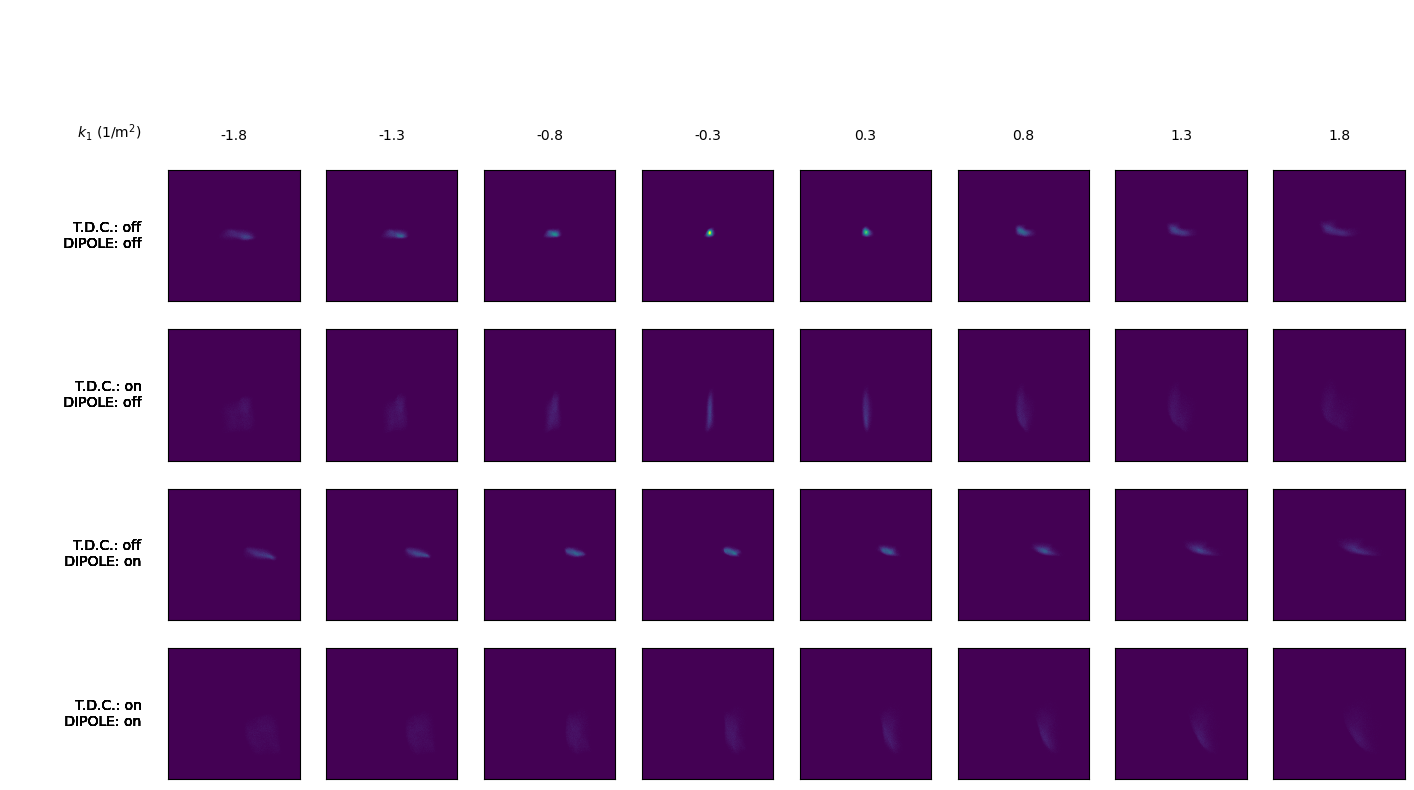

In [25]:
plot_3d_scan_data_2screens(pred_dset, 0)
plt.show()

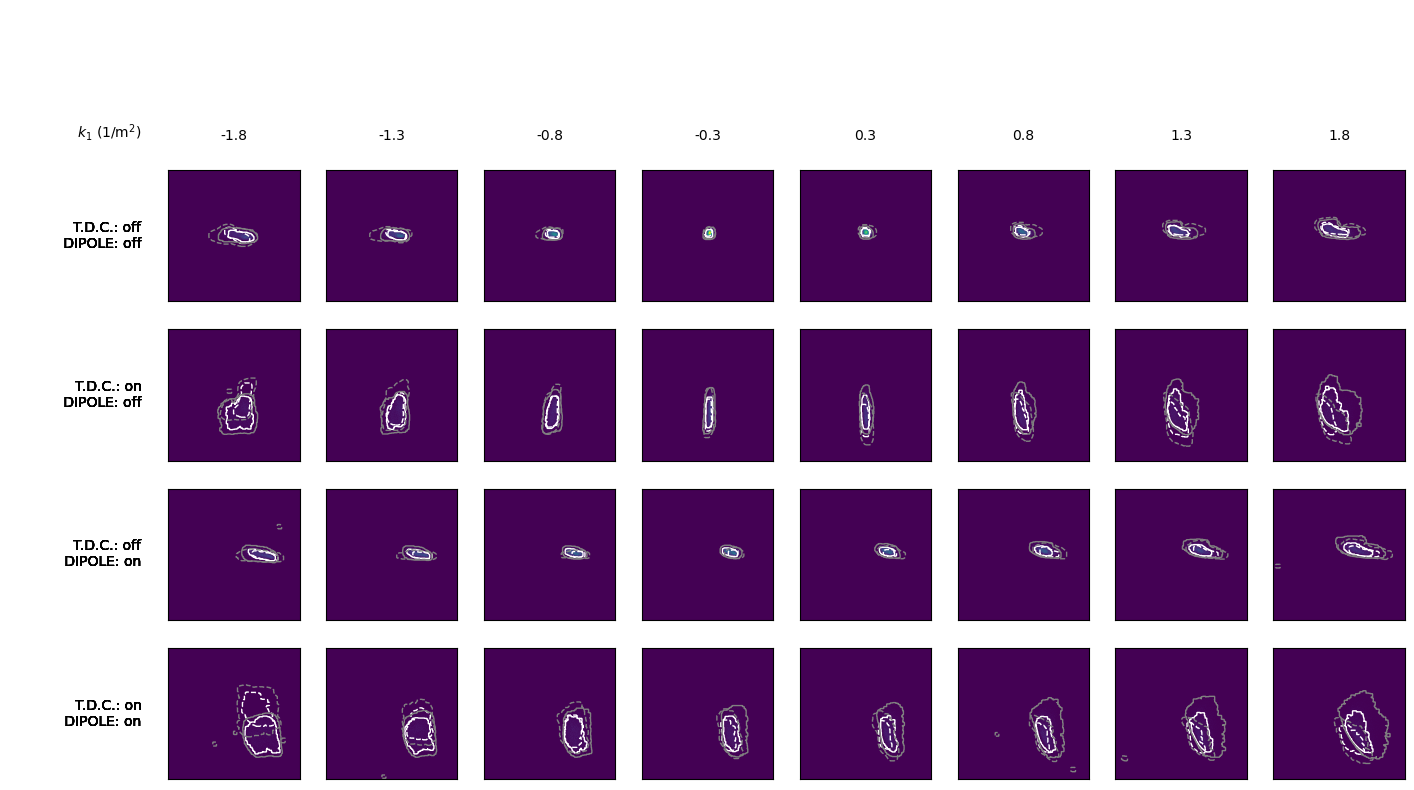

In [19]:
plot_3d_scan_data_2screens_contour(pred_dset, test_dset)
plt.show()